## Resolver ecuación de Stokes 2D en un cuadrado
Se plantea la ecuación de stokes 

$$ -\nu \Delta u + \rho^{-1}\nabla P = f $$
$$ \nabla \cdot u = 0$$


El dominio es $\Omega = [0,1]\times[0,1]$.



In [1]:
import numpy as np
from skfem import (
    MeshTri, Basis, ElementTriP2, ElementTriP1, ElementVector,
    asm, bmat, condense, solve
)
from skfem.models.general import divergence
from skfem.models.poisson import vector_laplace
from skfem.helpers import laplacian
import matplotlib.pyplot as plt


In [2]:
def graficar_stokes(u_sol, p_sol, mesh, basis_p, basis_u):
    
    Nu = basis_u.N
    
    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))

    # Separar componentes de velocidad
    # Para ElementVector, los DOFs están organizados por componente
    n_nodes = Nu // 2
    u_x = u_sol[0::2]  # componente x
    u_y = u_sol[1::2]  # componente y

    # Magnitud de velocidad
    u_magnitude = np.sqrt(u_x**2 + u_y**2)

    # Crear bases escalares para visualizar cada componente
    basis_scalar = Basis(mesh, ElementTriP2(), intorder=4)

    # Componente u de la velocidad
    basis_scalar.plot(u_x, ax=axes[0, 0], shading='gouraud', colorbar=True)
    axes[0, 0].set_title(r'Velocidad $u_x$ (horizontal)')
    axes[0, 0].set_aspect('equal')

    # Componente v de la velocidad
    basis_scalar.plot(u_y, ax=axes[0, 1], shading='gouraud', colorbar=True)
    axes[0, 1].set_title(r'Velocidad $u_y$ (vertical)')
    axes[0, 1].set_aspect('equal')

    # Magnitud de velocidad
    basis_scalar.plot(u_magnitude, ax=axes[1, 0], shading='gouraud', colorbar=True)
    axes[1, 0].set_title(r'Magnitud de velocidad $|\mathbf{u}|$')
    axes[1, 0].set_aspect('equal')

    # Presión
    basis_p.plot(p_sol, ax=axes[1, 1], shading='gouraud', colorbar=True)
    axes[1, 1].set_title(r'Presión $p$')
    axes[1, 1].set_aspect('equal')

    plt.tight_layout()
    plt.show()

def graficar_laplaciano(mesh, lap_u_x, lap_u_y, lap_p):

    plt.figure(figsize=(8,6))
    scatter_ux = plt.tripcolor(mesh.p[0], mesh.p[1], mesh.t.T, 
                            lap_u_x, 
                            shading='flat', 
                            cmap='RdBu_r')
    plt.colorbar(scatter_ux, label='$\\Delta u_x$', shrink=0.5)
    plt.title('Laplaciano numérico $\\Delta u_x$ (por elemento)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.gca().set_aspect('equal')
    plt.show()

    # Laplaciano de u_y
    plt.figure(figsize=(8,6))
    scatter_uy = plt.tripcolor(mesh.p[0], mesh.p[1], mesh.t.T, 
                            lap_u_y, 
                            shading='flat', 
                            cmap='RdBu_r')
    plt.colorbar(scatter_uy, label='$\\Delta u_y$', shrink=0.5)
    plt.title('Laplaciano numérico $\\Delta u_y$ (por elemento)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.gca().set_aspect('equal')
    plt.show()

    # Laplaciano de la presión
    plt.figure(figsize=(8,6))
    scatter_p = plt.tripcolor(mesh.p[0], mesh.p[1], mesh.t.T, 
                            lap_p, 
                            shading='flat', 
                            cmap='RdBu_r')
    plt.colorbar(scatter_p, label='$\\Delta p$', shrink=0.5)
    plt.title('Laplaciano numérico $\\Delta p$ (por elemento)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.gca().set_aspect('equal')
    plt.show()

In [3]:
# Definir dominio y mallado
nx, ny = 10, 10
mesh = MeshTri.init_tensor(
    np.linspace(0.0, 1.0, nx + 1), 
    np.linspace(0.0, 1.0, ny + 1)
)
# mesh = MeshTri.init_symmetric().refined(3)

In [4]:
# Asignar ID a las fronteras

mesh = mesh.with_boundaries({
    'left':   lambda x: x[0] == 0.0,
    'right':  lambda x: x[0] == 1.0,
    'bottom': lambda x: x[1] == 0.0,
    'top':    lambda x: x[1] == 1.0,
})

In [5]:
# Definir elementos y bases (P2 para velocidad, P1 para presión)
element = {
    'u': ElementVector(ElementTriP2()),
    'p': ElementTriP1(),
}
basis = {
    'u': Basis(mesh, element['u'], intorder=4),
    'p': Basis(mesh, element['p'], intorder=4),
}

In [6]:
# Ensamblaje de matrices
A =  asm(vector_laplace, basis['u'])
B = -asm(divergence, basis['u'], basis['p'])

K = bmat([[A, B.T],
          [B, None]], format='csr')

# Vector de términos fuente (cero)
F_u = basis['u'].zeros()
F_p = basis['p'].zeros()
F = np.hstack([F_u, F_p])

In [7]:
# Configurar condiciones de borde
basis_u = basis['u']
basis_p = basis['p']
Nu      = basis_u.N
Np      = basis_p.N

# Perfil 

def u_exact_x(x, y):
    return 0*x + 1*y**2

def u_exact_y(x, y):
    return  x**2 + 0*y

def p_exact_xy(x, y):
    return 2*x + 2*y

# Obtener DOFs de las fronteras
dofs_left     = basis_u.get_dofs('left').all()
dofs_right    = basis_u.get_dofs('right').all()
dofs_top      = basis_u.get_dofs('top').all()
dofs_bottom   = basis_u.get_dofs('bottom').all()

# Elementos con condiciones de Dirichlet
# Impares y, pares x
y_left   = basis_u.doflocs[1, dofs_left[1::2]] 
y_right  = basis_u.doflocs[1, dofs_right[1::2]]

x_left   = basis_u.doflocs[0, dofs_left[::2]]  
x_right  = basis_u.doflocs[0, dofs_right[::2]]

x_top    = basis_u.doflocs[0, dofs_top[::2]]
x_bottom = basis_u.doflocs[0, dofs_bottom[::2]]

y_top    = basis_u.doflocs[1, dofs_top[1::2]]
y_bottom = basis_u.doflocs[1, dofs_bottom[1::2]]

x_boundary = np.zeros(Nu + Np)

x_boundary[dofs_left[::2]]    =  u_exact_x(x_left, y_left)  # componente x
x_boundary[dofs_left[1::2]]   =  u_exact_y(x_left, y_left)  # componente y

x_boundary[dofs_right[::2]]   =  u_exact_x(x_right, y_right)  # componente x
x_boundary[dofs_right[1::2]]  =  u_exact_y(x_right, y_right)  # componente y

x_boundary[dofs_top[::2]]     =  u_exact_x(x_top, y_top)  # componente x
x_boundary[dofs_top[1::2]]    =  u_exact_y(x_top, y_top)  # componente y

x_boundary[dofs_bottom[::2]]  =  u_exact_x(x_bottom, y_bottom)  # componente x
x_boundary[dofs_bottom[1::2]] =  u_exact_y(x_bottom, y_bottom)  # componente y

nodo0_p = np.array([0])
dofs_pressure = Nu + nodo0_p
x_boundary[dofs_pressure] = p_exact_xy(basis_p.doflocs[0][nodo0_p[0]], basis_p.doflocs[1][nodo0_p[0]])  

D_all = np.unique(np.concatenate([
    dofs_left,
    dofs_top,
    dofs_bottom,
    dofs_right,
    dofs_pressure 
]))

In [8]:
# Resolver sistema condensado
sol_full = solve(*condense(K, F, D=D_all, x=x_boundary))

# Extraer soluciones
u_sol = sol_full[:Nu]
p_sol = sol_full[Nu:]

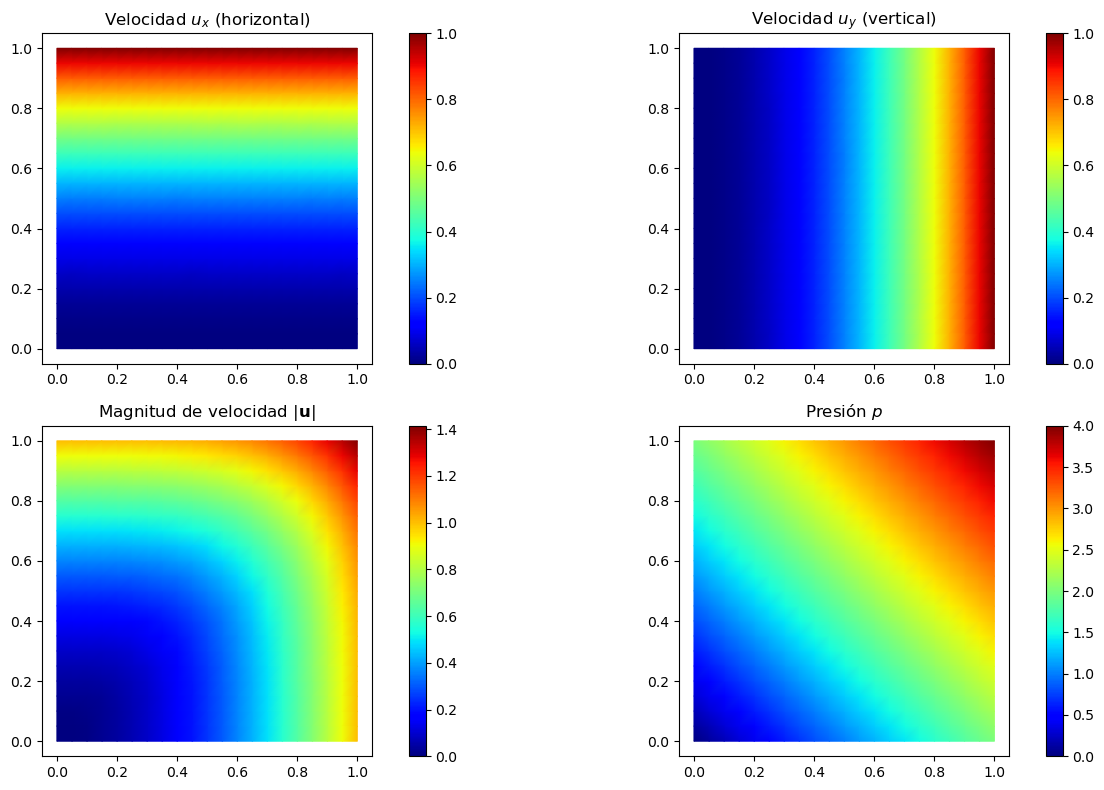

In [9]:
graficar_stokes(u_sol, p_sol, mesh, basis_p, basis_u)

In [10]:
# Velocidades
base_u1 = Basis(mesh, ElementTriP2(), intorder=4)
u_x = u_sol[0::2]  # componente x
u_y = u_sol[1::2]  # componente y
lap_u_x = laplacian(u_x, base_u1)
lap_u_y = laplacian(u_y, base_u1)

# Presion
base_p1 = Basis(mesh, ElementTriP1(), intorder=4)
lap_p = laplacian(p_sol, base_p1)

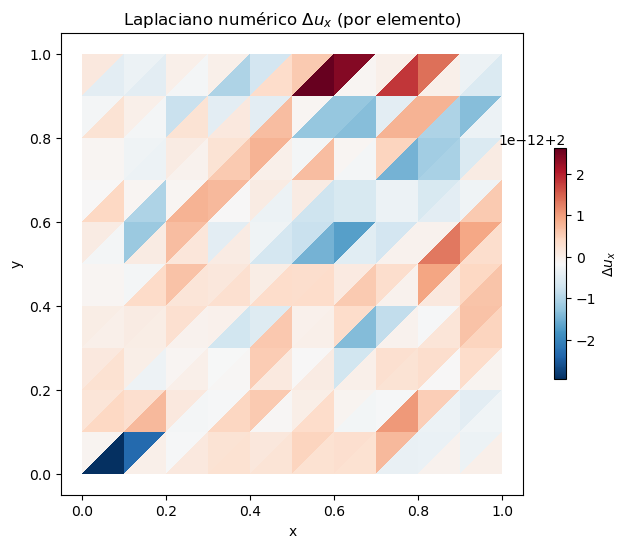

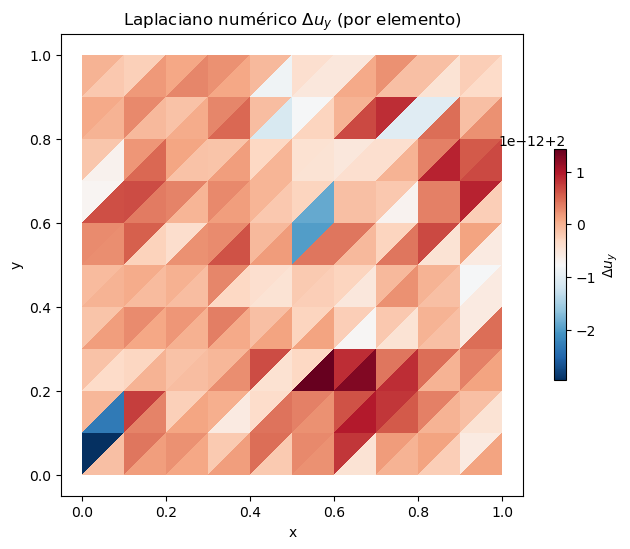

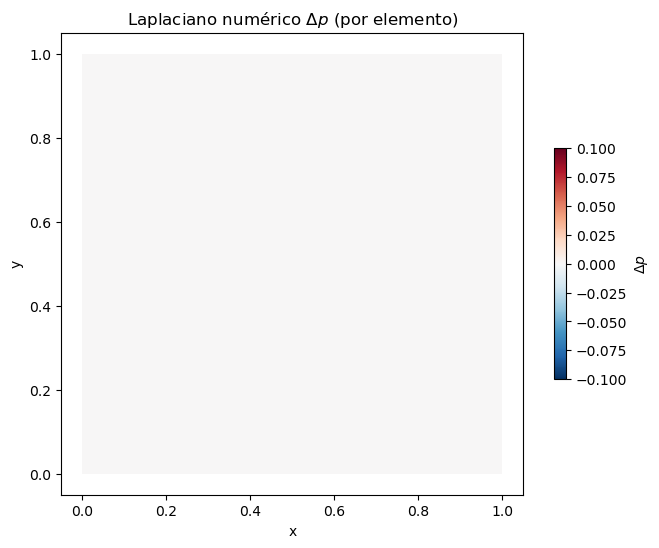

In [11]:
graficar_laplaciano(mesh, lap_u_x, lap_u_y, lap_p)